## 1.Correlation ##

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import os

# ====== Path Configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv"
out_path = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_facility_grdi_correlations.csv"

# ====== Read Data ======
df = pd.read_csv(csv_path)

# ====== Only keep columns necessary ======
facilities = ["education", "health", "publictransport", "shop", "green"]
grdi_cols = ["GRDI_MEAN"]
index_cols = [f"{f}_index" for f in facilities]

required_cols = ["NAME_2"] + grdi_cols + index_cols
df = df[required_cols].copy()

# ====== type transfer ======
for col in grdi_cols + index_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan)

# ====== correlation analytics ======
results = []
for fac in facilities:
    x = df[f"{fac}_index"]
    for grdi_col in grdi_cols:
        y = df[grdi_col]
        mask = x.notna() & y.notna()
        xn, yn = x[mask], y[mask]
        n = len(xn)
        if n >= 3:
            pearson_r, pearson_p = stats.pearsonr(xn, yn)
            spearman_r, spearman_p = stats.spearmanr(xn, yn)
        else:
            pearson_r = pearson_p = spearman_r = spearman_p = np.nan
        results.append({
            "facility": fac,
            "target": grdi_col,
            "N": n,
            "pearson_r": pearson_r,       # ← 不要 round
            "pearson_p": pearson_p,
            "spearman_rho": spearman_r,
            "spearman_p": spearman_p
        })

# ====== output ======
out_df = pd.DataFrame(results)
out_df = out_df.sort_values(["target", "facility"]).reset_index(drop=True)

# print
with pd.option_context('display.float_format', '{:.3e}'.format):
    print(out_df.to_string(index=False))

# save csv
out_df.to_csv(out_path, index=False, float_format="%.3e")


       facility    target   N  pearson_r  pearson_p  spearman_rho  spearman_p
      education GRDI_MEAN 172 -5.716e-01  2.650e-16    -6.798e-01   1.138e-24
          green GRDI_MEAN 172 -6.446e-01  1.407e-21    -4.235e-01   7.077e-09
         health GRDI_MEAN 172 -7.377e-01  8.091e-31    -6.270e-01   3.533e-20
publictransport GRDI_MEAN 172 -8.232e-01  1.170e-43    -4.933e-01   6.170e-12
           shop GRDI_MEAN 172 -7.245e-01  2.825e-29    -4.629e-01   1.616e-10


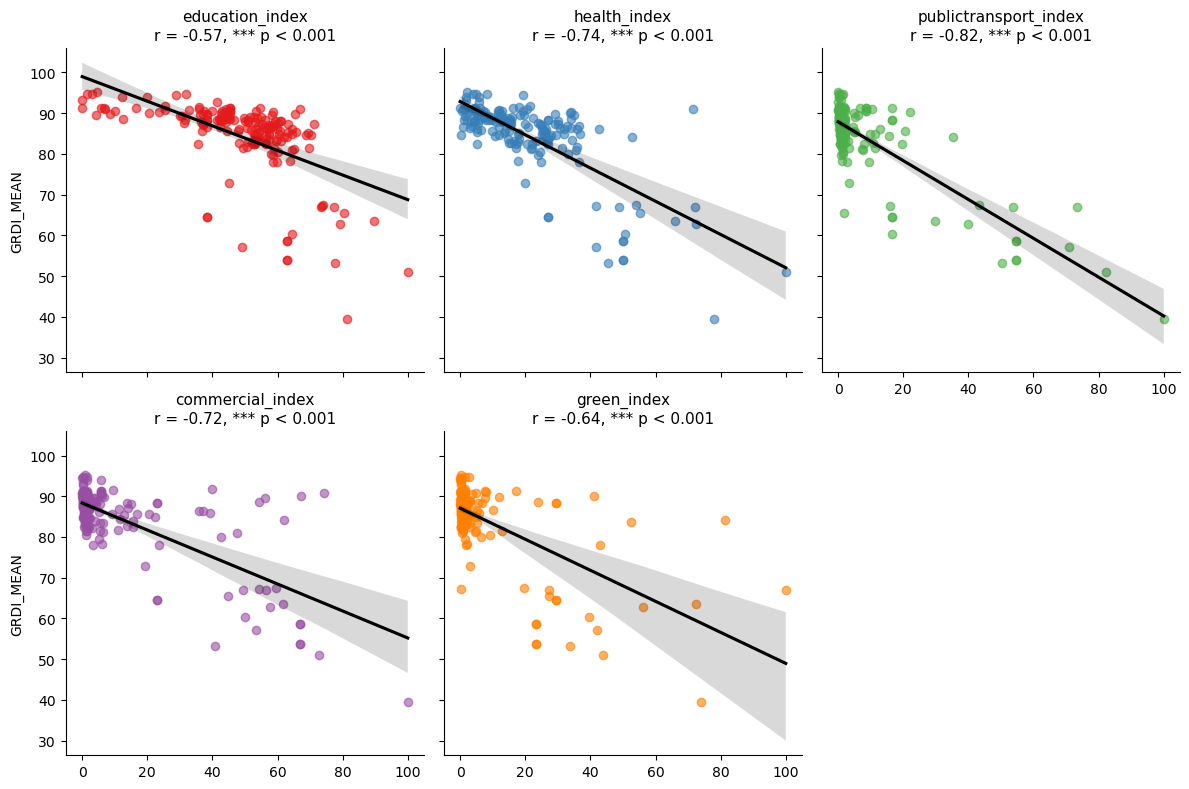

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# read data
df = pd.read_csv("/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv") 

# set variables
facilities = ["education_index", "health_index", "publictransport_index", "shop_index", "green_index"]
facility_display_map = {
    "education_index": "education_index",
    "health_index": "health_index",
    "publictransport_index": "publictransport_index",
    "commercial_index": "shop_index",
    "green_index": "green_index"
}
df_melted = df.melt(id_vars=["NAME_2", "GRDI_MEAN"], value_vars=facilities,
                    var_name="Facility Type", value_name="Access Index")
df_melted["Facility Display"] = df_melted["Facility Type"].replace({"shop_index": "commercial_index"})

# custom colour
facility_palette = {
    "education_index": "#e41a1c",
    "health_index": "#377eb8",
    "publictransport_index": "#4daf4a",
    "commercial_index": "#984ea3",
    "green_index": "#ff7f00"
}

# calculate r & p
correlation_results = {}
for fac in facilities:
    r, p = pearsonr(df[fac], df["GRDI_MEAN"])
    correlation_results[fac] = (r, p)

# Paint
g = sns.FacetGrid(df_melted, col="Facility Display", col_wrap=3, height=4, aspect=1)
for ax, f in zip(g.axes.flat, df_melted["Facility Display"].unique()):
    key = facility_display_map[f]
    color = facility_palette[f]
    subset = df_melted[df_melted["Facility Display"] == f]
    r, _ = correlation_results[key if key != "shop_index" else "shop_index"]
    sns.regplot(data=subset, x="Access Index", y="GRDI_MEAN", ax=ax,
                scatter_kws={"alpha": 0.6, "color": color},
                line_kws={"color": "black"})
    ax.set_title(f"{f}\nr = {r:.2f}, *** p < 0.001", fontsize=11)
    ax.set_xlabel("")
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
import numpy as np
from scipy import stats

# ====== Path Configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv"

# ====== Read Data ======
df = pd.read_csv(csv_path)

# ====== Extract Data ======
cols = ["composite_index", "GRDI_MEAN"]
df = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# ====== Set Function ======
def correlation_summary(x, y):
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]
    n = len(x)
    if n >= 3:
        pearson_r, pearson_p = stats.pearsonr(x, y)
        spearman_r, spearman_p = stats.spearmanr(x, y)
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
    return {
        "N": n,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_rho": spearman_r,
        "spearman_p": spearman_p
    }

# ====== Run ======
x = df["composite_index"]
summary_mean = correlation_summary(x, df["GRDI_MEAN"])

# ====== Construct Output Table ======
result_df = pd.DataFrame([
    {"target": "GRDI_MEAN", **summary_mean}
])

# ====== Output ======
with pd.option_context('display.float_format', '{:.3e}'.format):
    print(result_df.to_string(index=False))

# ====== Save CSV ======
result_df.to_csv("/Users/ruoxin/Downloads/dissertation/composite_grdi_correlation.csv", index=False, float_format="%.3e")


   target   N  pearson_r  pearson_p  spearman_rho  spearman_p
GRDI_MEAN 172 -8.430e-01  1.224e-47    -6.979e-01   1.970e-26


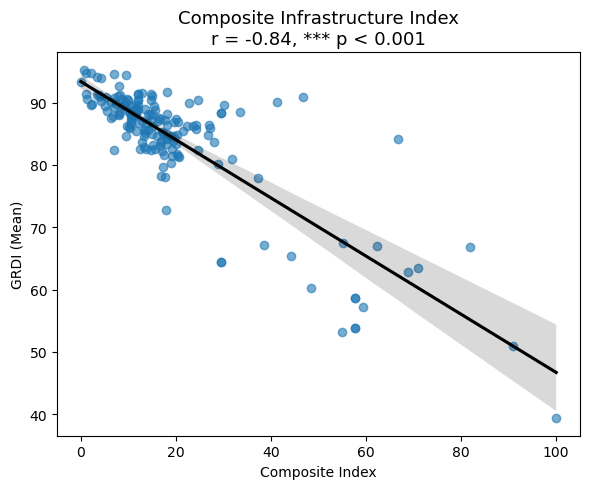

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read Data
df = pd.read_csv("/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv") 

# Extract Data
x = df["composite_index"]
y = df["GRDI_MEAN"]

# calculate  Pearson r & p
r, p = pearsonr(x, y)
significance_str = "*** p < 0.001" if p < 0.001 else f"p = {p:.3f}"

# Paint
plt.figure(figsize=(6, 5))
sns.regplot(x=x, y=y, scatter_kws={"alpha": 0.6, "color": "#1f77b4"}, line_kws={"color": "black"})
plt.title(f"Composite Infrastructure Index\nr = {r:.2f}, {significance_str}", fontsize=13)
plt.xlabel("Composite Index")
plt.ylabel("GRDI (Mean)")
plt.tight_layout()
plt.show()


## 2.OLS Regression ##

In [33]:
import pandas as pd
import statsmodels.api as sm
import os

# ====== Path Configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv"
out_path = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_composite_grdi_regression.csv"

# ====== Read Data======
df = pd.read_csv(csv_path)
df["composite_index"] = pd.to_numeric(df["composite_index"], errors="coerce")
df["GRDI_MEAN"] = pd.to_numeric(df["GRDI_MEAN"], errors="coerce")
df_clean = df.dropna(subset=["composite_index", "GRDI_MEAN"])

# ====== Correlation Analytics ======
results = []

def run_ols_and_store(y_col):
    X = df_clean[["composite_index"]]
    X = sm.add_constant(X)
    y = df_clean[y_col]
    model = sm.OLS(y, X).fit()

    intercept = model.params["const"]
    slope = model.params["composite_index"]
    r_squared = model.rsquared
    p_value = model.pvalues["composite_index"]

    # Function
    sign = "+" if slope >= 0 else "-"
    equation = f"{y_col} = {intercept:.4f} {sign} {abs(slope):.4f} × CompositeIndex"

    print(f"\n===== OLS Regression: {y_col} ~ composite_index =====")
    print(model.summary())

    results.append({
        "target": y_col,
        "intercept": round(intercept, 4),
        "slope": round(slope, 4),
        "R_squared": round(r_squared, 4),
        "p_value": "{:.3e}".format(p_value),
        "equation": equation
    })

run_ols_and_store("GRDI_MEAN")

# ====== Save CSV ======
pd.DataFrame(results).to_csv(out_path, index=False)



===== OLS Regression: GRDI_MEAN ~ composite_index =====
                            OLS Regression Results                            
Dep. Variable:              GRDI_MEAN   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     417.4
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.22e-47
Time:                        00:50:18   Log-Likelihood:                -523.17
No. Observations:                 172   AIC:                             1050.
Df Residuals:                     170   BIC:                             1057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

## 3.OLS Residual Moran’s I ##

=== Moran’s I for OLS residuals ===


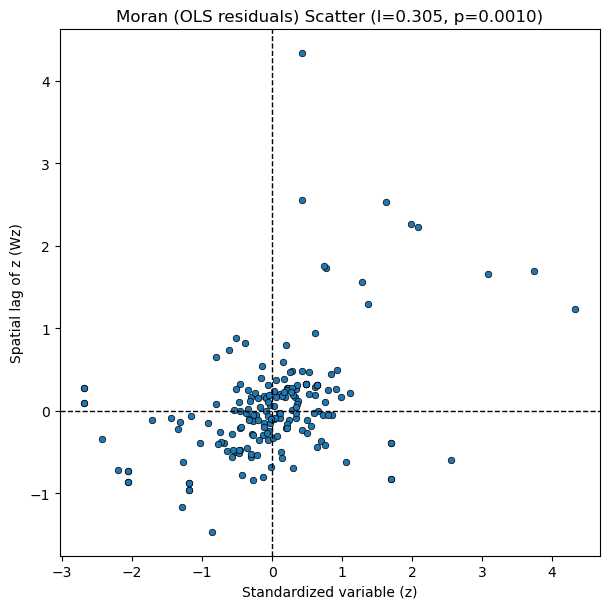

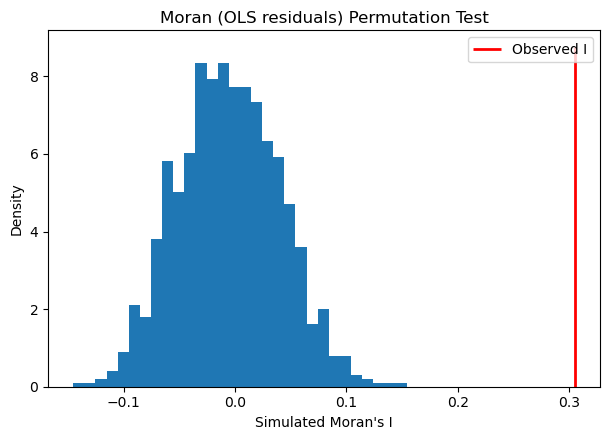

[Moran’s I] I=0.3050, E[I]=-0.0055, p=0.001, z=6.808


In [24]:
# -*- coding: utf-8 -*-
# OLS Residual Moran's I
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from libpysal.weights import Queen, KNN
from libpysal.weights.spatial_lag import lag_spatial
from esda.moran import Moran
import statsmodels.api as sm

# ===================== Path =====================
GPKG_PATH = "/Users/ruoxin/Downloads/dissertation/qgis/UGA_2.gpkg"      # Boundaries
CSV_PATH  = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv" # Variables
JOIN_KEY  = "NAME_2"               # Join Key
Y_COL     = "GRDI_MEAN"            # Denpendant（y）
X_COLS    = ["composite_index"]    # Independent 
# ===============================================================

# 1) Read Data & Merge
gdf = gpd.read_file(GPKG_PATH)
df  = pd.read_csv(CSV_PATH)

gdf[JOIN_KEY] = gdf[JOIN_KEY].astype(str).str.strip()
df[JOIN_KEY]  = df[JOIN_KEY].astype(str).str.strip()
gdf = gdf.merge(df, on=JOIN_KEY, how="inner").reset_index(drop=True)

# 2) Construct Space Weight 
try:
    w = Queen.from_dataframe(gdf)
    if w.islands:
        print(f"Found")
        w = KNN.from_dataframe(gdf, k=4)
except Exception as e:
    print("Construct Failed: ", e)
    w = KNN.from_dataframe(gdf, k=4)
w.transform = "r"  # Standardization 

# 3) Paint
def moran_plot(series, w, title_prefix="Moran (OLS residuals)", bins=30):
    y = pd.Series(series, dtype=float).replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
    mi = Moran(y.values, w)

    # 标准化与空间滞后
    z = (y - y.mean()) / y.std(ddof=1)
    wz = pd.Series(lag_spatial(w, z.values))

    # Moran scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 6.2))
    ax.scatter(z, wz, edgecolor="k", linewidths=0.5, s=22)
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Standardized variable (z)")
    ax.set_ylabel("Spatial lag of z (Wz)")
    ax.set_title(f"{title_prefix} Scatter (I={mi.I:.3f}, p={mi.p_sim:.4f})")
    plt.tight_layout()
    plt.show()

    # Histogram 
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.5))
    ax.hist(mi.sim, bins=bins, density=True)
    ax.vlines(mi.I, 0, ax.get_ylim()[1], color="red", linewidth=2, label="Observed I")
    ax.set_xlabel("Simulated Moran's I")
    ax.set_ylabel("Density")
    ax.set_title(f"{title_prefix} Permutation Test")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"[Moran’s I] I={mi.I:.4f}, E[I]={mi.EI:.4f}, p={mi.p_sim:.4g}, z={mi.z_norm:.3f}")
    return mi

# 4) Calculate OLS Residual Moran's I

Y = gdf[Y_COL].astype(float)
X = gdf[X_COLS].astype(float)
X = sm.add_constant(X)

ols = sm.OLS(Y, X).fit()

resid = ols.resid.values
print("=== Moran’s I for OLS residuals ===")
mi_resid = moran_plot(resid, w, title_prefix="Moran (OLS residuals)")


## 4.SEM ##

In [30]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
import numpy as np

# PySAL / spreg
from libpysal.weights import Queen, Rook
from libpysal import weights
from esda.moran import Moran
from spreg import ML_Error, GM_Error, GM_Error_Het  # SEM variants

# ========= 1) Read Data =========
gpkg_path = "/Users/ruoxin/Downloads/dissertation/qgis/UGA_2.gpkg"      
csv_path  = "/Users/ruoxin/Downloads/dissertation/Uganda/uganda_grdi_zonal.csv"  
gdf = gpd.read_file(gpkg_path)[["NAME_2","geometry"]].copy()
df  = pd.read_csv(csv_path)

# Unit Key Name
key = "NAME_2"
df[key] = df[key].astype(str).str.strip()
gdf[key] = gdf[key].astype(str).str.strip()

data = gdf.merge(df, on=key, how="inner")

# ========= 2) Choose independent & denpendant variables =========
# Denpendant: GRDI_Mean
y_col = "GRDI_MEAN"
# Independent variables: Composite Index
X_cols = ["composite_index"]  

# Discard
model_df = data[[y_col] + X_cols].replace([np.inf, -np.inf], np.nan).dropna().copy()
data = data.loc[model_df.index].reset_index(drop=True)
model_df = model_df.reset_index(drop=True)

# ========= 3) Construct Space Weight Metrix =========
W = Queen.from_dataframe(data)   
W.transform = "r"                

# ========= 4) organise metrix =========
y = model_df[[y_col]].values
X = model_df[X_cols].values

# ========= 5)  OLS Residual Moran’s I =========
moran_ols = None
try:
    import statsmodels.api as sm
    ols_fit = sm.OLS(y, sm.add_constant(X)).fit()
    residuals = np.asarray(ols_fit.resid).reshape(-1,1)
    moran_ols = Moran(residuals, W)
    print(f"[OLS Residual Moran’s I] I={moran_ols.I:.4f}, p={moran_ols.p_sim:.4f}")
except Exception as e:
    print("Failed: ", e)

# ========= 6) SEM =========
# 6.1 ML-Error
ml_sem = ML_Error(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", spat_diag=True, name_ds="Ghana_L2")
print("\n=== ML-Error (SEM) ===")
print(ml_sem.summary)

# 6.2 GM-Error（
gm_sem = GM_Error(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", name_ds="Ghana_L2")
print("\n=== GM-Error (SEM, GMM) ===")
print(gm_sem.summary)

# 6.3 GM-Error-Het
gm_sem_het = GM_Error_Het(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", name_ds="Ghana_L2")
print("\n=== GM-Error-Het (SEM, GMM-Het-robust) ===")
print(gm_sem_het.summary)

# ========= 7) Output =========
def tidy_sem_result(res):
    out = {
        "lambda": getattr(res, "lam", np.nan),
        "lambda_p": getattr(res, "lam_p_value", np.nan) if hasattr(res, "lam_p_value") else np.nan,
        "AIC": getattr(res, "aic", np.nan) if hasattr(res, "aic") else np.nan,
        "logll": getattr(res, "logll", np.nan) if hasattr(res, "logll") else np.nan,
        "n": getattr(res, "n", len(y)),
        "k": getattr(res, "k", X.shape[1]+1),  # +1 for intercept if any
    }
    try:
        names = res.name_x
        betas = res.betas.flatten()
        out["intercept"] = betas[0]
        for i, name in enumerate(names, start=1):
            out[f"beta_{name}"] = betas[i]
    except Exception:
        pass
    return out

print("\n--- Key numbers (for writing) ---")
print("ML-Error:", tidy_sem_result(ml_sem))
print("GM-Error:", tidy_sem_result(gm_sem))
print("GM-Error-Het:", tidy_sem_result(gm_sem_het))

# ========= 8) SEM Residual Moran’s I =========
try:
    # ML-Error Residual 
    res_ml = ml_sem.u  # residuals
    moran_ml = Moran(res_ml.reshape(-1,1), W)
    print(f"\n[SEM Residual Moran’s I] I={moran_ml.I:.4f}, p={moran_ml.p_sim:.4f}")
except Exception as e:
    print("Failed: ", e)


[OLS Residual Moran’s I] I=0.3050, p=0.0010

=== ML-Error (SEM) ===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :    Ghana_L2
Weights matrix      :       Queen
Dependent Variable  :   GRDI_MEAN                Number of Observations:         184
Mean dependent var  :     83.6554                Number of Variables   :           2
S.D. dependent var  :     10.2838                Degrees of Freedom    :         182
Pseudo R-squared    :      0.7187
Log likelihood      :   -558.5055
Sigma-square ML     :     24.2951                Akaike info criterion :    1121.011
S.E of regression   :      4.9290                Schwarz criterion     :    1127.441

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------